In [69]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F
import torch.nn as nn
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Device

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preapare data

In [16]:
batch_size = 64

### Data transform

In [17]:
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [18]:
train_dataset = MNIST(root="../../data",train=True,
                      download=True, transform=data_transforms)

test_dataset = MNIST(root="../../data",train=False,download=True,
                     transform=data_transforms)

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,
                          shuffle=True)
test_dataset = DataLoader(dataset=test_dataset,batch_size=batch_size,
                          shuffle=False)

### Visualization

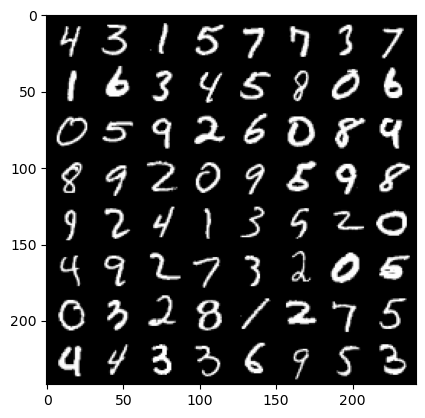

In [59]:
sample = iter(train_loader)
sample = next(sample)

images, labels = sample
classes = MNIST.classes
num_classes = len(classes)


n_rows = n_cols = 8

def show(imgs_grid):
    imgs_grid = imgs_grid.detach()
    imgs_grid = F.to_pil_image(imgs_grid)
    
    plt.imshow(np.asarray(imgs_grid))
    plt.show()

imgs_grid = torchvision.utils.make_grid(images)


show(imgs_grid)
        

## Model

In [74]:
seq_length = 28
input_size = 28
hidden_size = 128
num_layers = 2

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Size h0: D*num_layers, N, H_out
        # D = 1, N = batch_size, H_out = hidden_size
        
        h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size).to(device)
        
        # Size c0: D*num_layers, N, Hcell(hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        output, _ = self.lstm(x, (h0, c0))
        output = output[:, -1, :]
        
        out = self.fc(output)
        return out
        
        

## Training

### Hyperparams

In [64]:
epochs = 1000
lr = 1e-3
plot_steps = 10
print_steps = 50


In [80]:
model = LSTMModel(input_size=input_size, hidden_size=hidden_size,
                  num_layers=num_layers, num_classes=num_classes).to(device)


In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.005)

current_loss = 0
loss_his = []

In [ ]:
for epoch in range(epochs):
    for images, labels in train_loader:
        images = images.reshape(-1, seq_length, input_size).to(device)
        labels = labels.to(device)
        
        
        # Forward
        output = model(images).to(device)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        current_loss += loss.item()
    if (epoch + 1)%plot_steps == 0:
        loss_his.append(current_loss / plot_steps)
        current_loss = 0
    
    if (epoch + 1) % print_steps == 0:
        print(f"Epoch [{epoch + 1}/{epochs}]: Loss {loss.item():.4f}")